In [3]:
import scanpy as sc
import pandas as pd

import scanpy as sc
import sys
sys.path.append("/nfs/team298/sm54/BoneAtlasProject/src/annotation")
from helper_functions import save_obs, restore_obs

from pathlib import Path

# Add project root to sys.path
repo_root = Path("/nfs/team298/sm54/BoneAtlasProject")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Now import
from metadata.marker_genes.marker_dict import marker_dict

from metadata.marker_genes.marker_dict import CATEGORY_MARKERS_fbm, celltypist_lymphoid,celltypist_progenitors,s_genes,g2m_genes,T_Cells,T_cell_type_genes,tcell_diff_markers

import json
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import importlib, annotation
importlib.reload(annotation)
from annotation import (
    annotate_broad_topN,      # automatic broad annotation per cluster using marker enrichment
    extract_topN_from_rgg,    # extract top-N DEGs per cluster from scanpy rank_genes_groups
    top_genes_for_cluster,    # return DEGs for one cluster (table or list)
    attach_broad_annotations  # attach a manual/auto cluster→broad label mapping to adata.obs
)

# Read in the Object 

In [4]:
import scanpy as sc 
adata= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_FINAL_OBJECT_V3_FULL_GENES_FT.h5ad')

In [5]:
adata_ft= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/best_integration_final_ft/processed_adata/Best_Integration_bone_atlas_nlatent10_nlayers3_nhidden128_nhvg3000.h5ad')

In [22]:
del adata.obs['leiden_res_3_old']

In [23]:
adata.obs['leiden_res_3_old']=adata.obs['leiden_res_3'].copy()

In [8]:
# --- 1. Delete all .obsp entries
adata.obsp.clear()

# --- 2. Delete all .uns entries
adata.uns.clear()

# --- 3. Rename embeddings in .obsm
rename_map = {
    "X_scVI": "X_scVI_full_haem",
    "X_umap": "X_umap_full_haem"
}

for old, new in rename_map.items():
    if old in adata.obsm:
        adata.obsm[new] = adata.obsm.pop(old)

print("✅ Cleared .obsp and .uns, renamed embeddings.")
print("Remaining obsm keys:", list(adata.obsm.keys()))


✅ Cleared .obsp and .uns, renamed embeddings.
Remaining obsm keys: ['_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'old_X_scVI', 'old_X_scVI_with_doub', 'old_X_umap', 'old_X_umap_with_doub', 'X_scVI_full_haem', 'X_umap_full_haem']


In [9]:
adata

AnnData object with n_obs × n_vars = 50229 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfi

In [13]:
import numpy as np

# --- Check obs_names are identical ---
if not np.array_equal(adata.obs_names, adata_ft.obs_names):
    raise ValueError("Cell order mismatch between adata and adata_int!")

# --- 2. Transfer from adata_str ---
adata.obsp['X_scVI_connectivities'] = adata_ft.obsp['X_scVI_connectivities'].copy()
adata.obsp['X_scVI_distances'] = adata_ft.obsp['X_scVI_distances'].copy()
adata.obsm['X_scVI'] = adata_ft.obsm['X_scVI'].copy()
adata.obsm['X_umap'] = adata_ft.obsm['X_umap'].copy()
adata.uns['rank_genes_groups'] = adata_ft.uns['rank_genes_groups'].copy()

# --- 3. Transfer leiden_res_3 ---
adata.obs['leiden_res_3'] = adata_ft.obs['leiden_res_3'].copy()

print("✅ Old versions stored with 'with_doub' prefix, new data transferred from adata_int.")


✅ Old versions stored with 'with_doub' prefix, new data transferred from adata_int.


In [14]:
adata

AnnData object with n_obs × n_vars = 50229 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfi

In [15]:
adata.X= adata.layers['raw_counts'].copy()

In [16]:
adata.X.max()

16584.0

In [17]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [18]:
adata.X.max()

7.9230523

In [19]:
adata.write_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_FINAL_OBJECT_FT_INTERGATED_FULL_GENES.h5ad')

In [25]:
adata

AnnData object with n_obs × n_vars = 50229 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfi

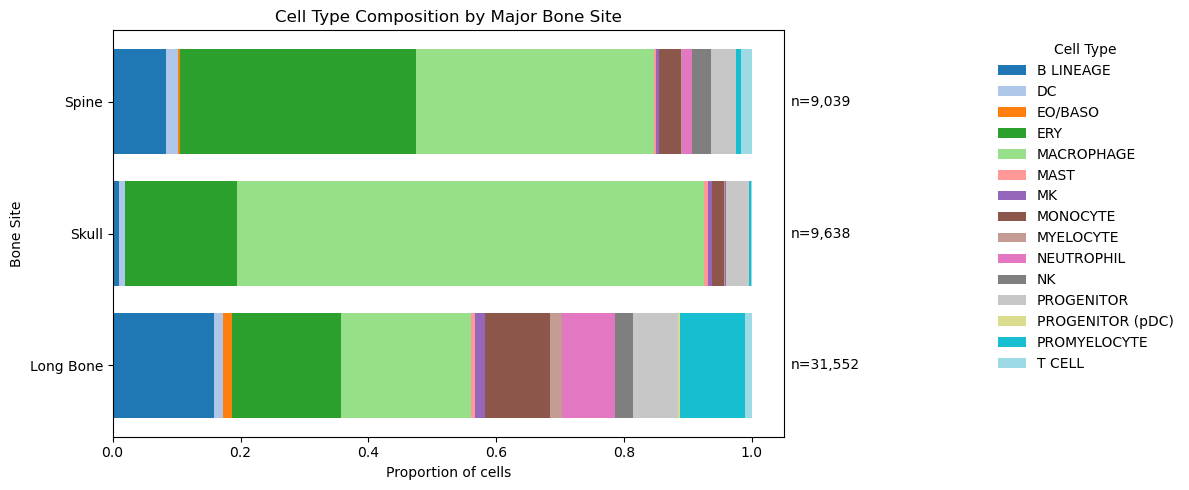

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

celltype_col = "Haem_Manual_Annotation_Level1_V4"
site_col     = "Major_Bone_Sites"

# Cross-tabulation
counts = pd.crosstab(adata.obs[site_col], adata.obs[celltype_col])
props  = counts.div(counts.sum(axis=1), axis=0)

# Categories & colors from Scanpy palette
cats = adata.obs[celltype_col].cat.categories
colors = adata.uns[celltype_col + "_colors"]

# Order sites by total cells (largest on top)
site_order = counts.sum(axis=1).sort_values(ascending=False).index

# Plot horizontal stacked bar
fig, ax = plt.subplots(figsize=(13, 5))
bottom = np.zeros(len(site_order))

for ct, color in zip(cats, colors):
    vals = props.loc[site_order, ct].values
    ax.barh(site_order, vals, left=bottom, color=color, edgecolor="none", label=ct)
    bottom += vals

# Add total cell count labels at end of bars
totals = counts.sum(axis=1)
# for i, site in enumerate(site_order):
#     ax.text(1.02, i, f"n={totals.loc[site]:,}", va="center")
for i, site in enumerate(site_order):
    ax.text(1.01, i, f"n={totals.loc[site]:,}",
            va="center", transform=ax.get_yaxis_transform())  


ax.set_xlim(0, 1.05)
ax.set_xlabel("Proportion of cells")
ax.set_ylabel("Bone Site")
ax.set_title("Cell Type Composition by Major Bone Site")
ax.legend(title="Cell Type", bbox_to_anchor=(1.3, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("barplot_haem_bone_sites_composition_ft.png", dpi=300, bbox_inches="tight")
plt.show()


In [29]:
adata.obs['FACS_Sorting'].value_counts()

FACS_Sorting
Total    29018
CD45+    13948
CD45-     7263
Name: count, dtype: int64

In [30]:
import pandas as pd 
#facs_prop_df = pd.read_csv("../../metadata/220621_FACs_gating_proportions_correct.csv")
facs_prop_df = pd.read_csv('/nfs/team205/ig7/resources/scripts_dont_modify/scMILO/FAC_gating/220621_FACs_gating_proportions_correct.csv')

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

In [31]:
facs_prop_df['Sanger_ID']=facs_prop_df['Sample.lanes'].copy()

In [34]:
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names

In [35]:
adata

AnnData object with n_obs × n_vars = 50229 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfi

In [36]:
adata.obs = new_obs.drop("_merge", axis=1).copy()

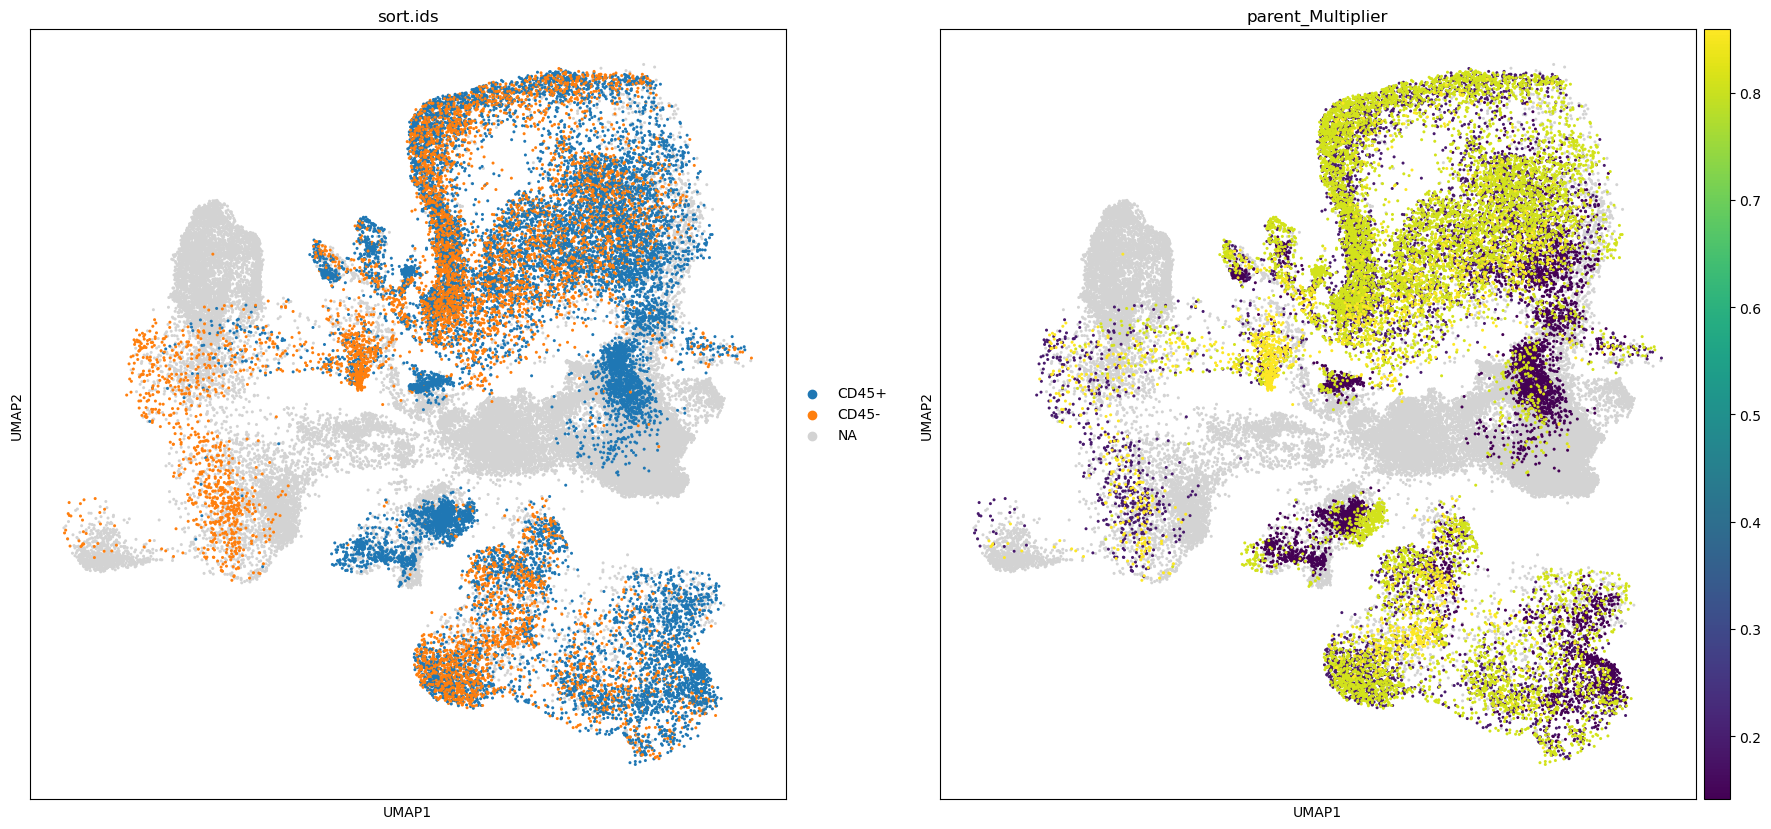

In [39]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["sort.ids","parent_Multiplier"], size=19)

In [40]:
smp_metadata = adata.obs[["sort.ids", "parent_Multiplier", "Major_Bone_Sites", "Age_Final", 'Sample.lanes', "Donor_Final"]].drop_duplicates()
smp_metadata['age']=pd.to_numeric(smp_metadata["Age_Final"], errors="coerce")

In [48]:
list(adata.obs['Haem_Manual_Annotation_Level1_V4'].unique())

['ERY',
 'MACROPHAGE',
 'MK',
 'PROGENITOR',
 'DC',
 'MAST',
 'MONOCYTE',
 'PROMYELOCYTE',
 'EO/BASO',
 'NEUTROPHIL',
 'B LINEAGE',
 'NK',
 'T CELL',
 'MYELOCYTE',
 'PROGENITOR (pDC)']